In [156]:
import os

In [157]:
IS_KAGGLE = "KAGGLE_KERNEL_RUN_TYPE" in os.environ
DATA_DIR = (
    "/kaggle/input/sentiment-analysis-on-movie-reviews"
    if IS_KAGGLE
    else "../data/sentiment-analysis-on-movie-reviews"
)

In [158]:
if not IS_KAGGLE:
	!kaggle competitions download -c sentiment-analysis-on-movie-reviews -f train.tsv.zip -p ../data/sentiment-analysis-on-movie-reviews
	!kaggle competitions download -c sentiment-analysis-on-movie-reviews -f test.tsv.zip -p ../data/sentiment-analysis-on-movie-reviews
	!kaggle competitions download -c sentiment-analysis-on-movie-reviews -f sampleSubmission.csv -p ../data/sentiment-analysis-on-movie-reviews

train.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [159]:
train_fname = DATA_DIR + "/train.tsv.zip"
test_fname = DATA_DIR + "/test.tsv.zip"
sub_fname = DATA_DIR + "/sampleSubmission.csv"

In [160]:
import pandas as pd

In [161]:
raw_df = pd.read_csv(train_fname, sep="\t")
raw_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [162]:
raw_df.Phrase.sample(10).values

array(['first directorial effort',
       'more harmless pranksters than political activists',
       'The hackneyed story about an affluent damsel in distress who decides to fight her bully of a husband is simply too overdone .',
       "enhances the quality of Neil Burger 's impressive fake documentary",
       "Allen 's execution date closes in", 'that special annex',
       'If you love reading and\\/or poetry',
       'gives voice to a story that needs to be heard in the sea of Holocaust movies',
       'Hollywood program', 'really'], dtype=object)

In [163]:
test_df = pd.read_csv(test_fname, sep="\t")
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [164]:
sub_df = pd.read_csv(sub_fname)
sub_df.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [165]:
raw_df.Sentiment.value_counts(normalize=True)

Sentiment
2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: proportion, dtype: float64

<Axes: >

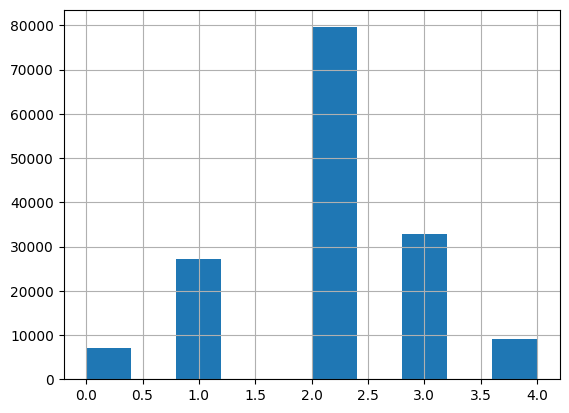

In [166]:
raw_df.Sentiment.hist()

## Learn Vocabulary using `TfidfVectorizer`

-   Create custom tokenizer with stemming
-   Create a list of stop words
-   Configure and create `TfidfVectorizer`
-   Learn vocabulary from training data
-   View sample entries from vocabulary


In [167]:
import nltk

nltk.download("punkt")
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [168]:
stemmer = SnowballStemmer("english")

In [169]:
def tokenize(text):
    return [
        stemmer.stem(token) for token in word_tokenize(text.lower()) if token.isalnum()
    ]

In [170]:
tokenize("Is this (the) real life? Is this just fantasy?")

['is', 'this', 'the', 'real', 'life', 'is', 'this', 'just', 'fantasi']

In [171]:
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [172]:
english_stopwords = stopwords.words("english")

In [173]:
selected_stopwords = english_stopwords[:115]

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [175]:
tfidf = TfidfVectorizer(
    tokenizer=tokenize,
    stop_words=selected_stopwords,
    ngram_range=(1, 2),  # unigrams and bigrams
    max_features=2000,
)

In [176]:
tfidf.fit(raw_df.Phrase)  # train on the entire dataset

/Users/macbook/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/macbook/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'ourselv', 'themselv', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x49e567060>)

## Transform Training & Test Data

-   Transform phrases from training set
-   Transform phrases from test set
-   Look at some example values


In [177]:
inputs = tfidf.transform(raw_df.Phrase)  # transform the entire dataset

In [178]:
inputs.shape

(156060, 2000)

In [179]:
import numpy as np

test_inputs = tfidf.fit_transform(
    test_df.Phrase.apply(lambda x: np.str_(x))
)  # transform the test dataset

In [180]:
test_inputs.shape

(66292, 2000)

## Train Baseline Model & Submit Predictions

1. Split training and validation data
2. Train logistic regression model
3. Study predictions on sample phrases
4. Make predictions and submit to Kaggle


In [181]:
TRAIN_SIZE = 110_000

In [182]:
train_inputs = inputs[:TRAIN_SIZE]
train_targets = raw_df.Sentiment[:TRAIN_SIZE]

val_inputs = inputs[TRAIN_SIZE:]
val_targets = raw_df.Sentiment[TRAIN_SIZE:]

In [183]:
train_inputs.shape, val_inputs.shape

((110000, 2000), (46060, 2000))

## Train Logistic Regression Model


In [184]:
from sklearn.linear_model import LogisticRegression

In [185]:
model = LogisticRegression(max_iter=1000, class_weight="balanced")

In [186]:
model.fit(train_inputs, train_targets)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [187]:
train_preds = model.predict(train_inputs)

In [188]:
from sklearn.metrics import accuracy_score

In [189]:
accuracy_score(train_targets, train_preds)

0.5416727272727273

In [190]:
val_preds = model.predict(val_inputs)

In [191]:
accuracy_score(val_targets, val_preds)

0.4693226226660877

## Study Predictions on Sample Phrases


In [192]:
small_df = raw_df.sample(20)

In [193]:
small_df

,PhraseId,SentenceId,Phrase,Sentiment
35447,35448,1668,the stills,2
140142,140143,7604,one truth,2
112011,112012,5945,is that it 's not as obnoxious as Tom Green 's...,1
103158,103159,5441,is virtually absent,1
123443,123444,6627,"Drug abuse , infidelity",2
52144,52145,2574,Nicholson 's understated performance is wonder...,4
82069,82070,4233,for Chaiken,2
119815,119816,6409,that Stealing Harvard is too busy getting in i...,0
81365,81366,4193,both the beauty,3
82145,82146,4238,want to live their lives,2


In [194]:
small_inputs = tfidf.transform(small_df.Phrase)
small_inputs.shape

(20, 2000)

In [195]:
small_preds = model.predict(small_inputs)
small_preds

array([0, 3, 4, 2, 0, 3, 2, 3, 2, 4, 1, 3, 1, 1, 2, 1, 2, 3, 2, 2])

In [196]:
test_preds = model.predict(test_inputs)
test_preds

array([3, 3, 2, ..., 2, 2, 1])

In [197]:
sub_df.Sentiment = test_preds
sub_df.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


In [198]:
sub_df.to_csv(DATA_DIR + "/submission.csv", index=False)
!head $DATA_DIR/submission.csv

PhraseId,Sentiment
156061,3
156062,3
156063,2
156064,3
156065,3
156066,3
156067,3
156068,3
156069,3


## Naive Bayes Model


In [199]:
from sklearn.naive_bayes import MultinomialNB

In [205]:
model1 = MultinomialNB(class_prior=(0.05, 0.2, 0.5, 0.2, 0.05))

In [206]:
model1.fit(train_inputs, train_targets)

MultinomialNB(class_prior=(0.05, 0.2, 0.5, 0.2, 0.05))

In [209]:
accuracy_score(train_targets, model1.predict(train_inputs))

0.5882181818181819

In [210]:
accuracy_score(val_targets, model1.predict(val_inputs))

0.5453755970473295